In [1]:
import pandas as pd
import numpy as np
# import required libraries for tree based models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
droppedna_merged_df =  pd.read_csv('embedded_updated_label.csv')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight



# Split the data into training and validation sets
train_df, val_df = train_test_split(droppedna_merged_df, test_size=0.2, random_state=42)

# Extract features (embeddings) and labels
X_train = train_df.iloc[:, -769:-1]  # Assuming embeddings start from the third column
y_train = train_df['Type']

X_val = val_df.iloc[:, -769:-1]
y_val = val_df['Type']

# Calculate class weights based on the inverse of the number of members in each class
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)






In [5]:
# Define a simple feedforward neural network with customizable hidden layers
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()

        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            in_size = hidden_size

        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # Assuming the input size is the number of features in the embeddings
hidden_sizes = [512, 512, 512, 256, 256]  # Customize hidden layer sizes
output_size = len(np.unique(y_train))
model = SimpleNN(input_size, hidden_sizes, output_size)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# Variables for early stopping
best_val_loss = np.inf
no_improvement_count = 0
early_stopping_threshold = 20  # Number of consecutive epochs without improvement to trigger early stopping
model_checkpoint_path = '768_512_512_512_256_256_3_SentEmb_NN.pth'  # Path to save the model checkpoint

In [6]:
# Training loop with early stopping
epochs = 1000
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    _, predicted_train = torch.max(outputs, 1)
    train_accuracy = (predicted_train == y_train_tensor).sum().item() / len(y_train_tensor)

    # Validation loss and accuracy
    with torch.no_grad():
        model.eval()
        X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

        _, predicted_val = torch.max(val_outputs, 1)
        val_accuracy = (predicted_val == y_val_tensor).sum().item() / len(y_val_tensor)

    # Print loss and accuracy for monitoring training progress
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save the model checkpoint
        torch.save(model.state_dict(), model_checkpoint_path)
    else:
        no_improvement_count += 1

    # Check if early stopping criteria met
    if no_improvement_count >= early_stopping_threshold:
        print(f'Early stopping triggered after {epoch+1} epochs without improvement.')
        break


Epoch [1/1000], Loss: 1.0995628833770752, Training Accuracy: 0.0286, Validation Loss: 1.098246455192566, Validation Accuracy: 0.0279
Epoch [2/1000], Loss: 1.0983126163482666, Training Accuracy: 0.0286, Validation Loss: 1.0969713926315308, Validation Accuracy: 0.9440
Epoch [3/1000], Loss: 1.0969460010528564, Training Accuracy: 0.9442, Validation Loss: 1.0940450429916382, Validation Accuracy: 0.9452
Epoch [4/1000], Loss: 1.0939387083053589, Training Accuracy: 0.9453, Validation Loss: 1.0879740715026855, Validation Accuracy: 0.8696
Epoch [5/1000], Loss: 1.0876784324645996, Training Accuracy: 0.8677, Validation Loss: 1.0777024030685425, Validation Accuracy: 0.6009
Epoch [6/1000], Loss: 1.0770527124404907, Training Accuracy: 0.6021, Validation Loss: 1.0626188516616821, Validation Accuracy: 0.3536
Epoch [7/1000], Loss: 1.0614511966705322, Training Accuracy: 0.3590, Validation Loss: 1.041427731513977, Validation Accuracy: 0.2884
Epoch [8/1000], Loss: 1.039685606956482, Training Accuracy: 0.29

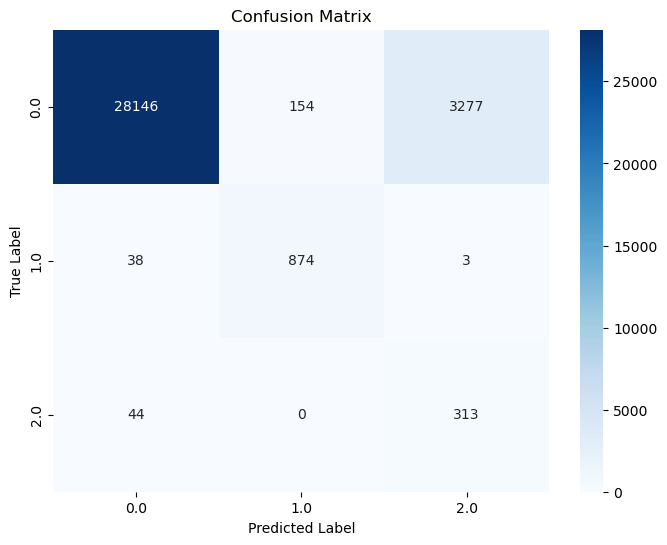

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model checkpoint
model.load_state_dict(torch.load(model_checkpoint_path))

# Make predictions on the validation set
with torch.no_grad():
    model.eval()
    val_outputs = model(torch.tensor(X_val.values, dtype=torch.float32))
    _, predicted_labels = torch.max(val_outputs, 1)

# Convert predicted labels to numpy array
predicted_labels_np = predicted_labels.numpy()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, predicted_labels_np)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Macro Precision: 0.6448, Recall: 0.9078, F1-score: 0.6665
Micro Precision: 0.8930, Recall: 0.8930, F1-score: 0.8930
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     31577
           1       0.85      0.96      0.90       915
           2       0.09      0.88      0.16       357

    accuracy                           0.89     32849
   macro avg       0.64      0.91      0.67     32849
weighted avg       0.98      0.89      0.93     32849



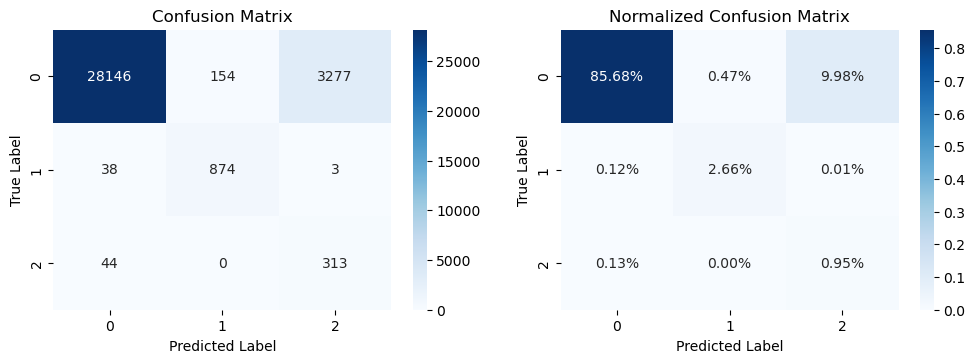

In [18]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model checkpoint
model.load_state_dict(torch.load(model_checkpoint_path))

# Make predictions on the validation set
with torch.no_grad():
    model.eval()
    val_outputs = model(torch.tensor(X_val.values, dtype=torch.float32))
    _, predicted_labels = torch.max(val_outputs, 1)

# Convert predicted labels to numpy array
predicted_labels_np = predicted_labels.numpy()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, predicted_labels_np)

# Display the confusion matrix using seaborn
plt.figure(figsize=(12, 8))

# Plot Confusion Matrix
plt.subplot(2, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0','1','2'], yticklabels=['0','1','2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Calculate macro and micro average metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_val, predicted_labels_np, average='macro')
print(f"Macro Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_val, predicted_labels_np, average='micro')
print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1-score: {f1_micro:.4f}")

# Display the classification report
class_report = classification_report(y_val, predicted_labels_np, target_names=['0','1','2'])
print("Classification Report:\n", class_report)

# Plot Normalized Confusion Matrix
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=['0','1','2'], yticklabels=['0','1','2'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()


In [8]:
# Perform PCA on the last hidden layer output

# Load the best model checkpoint
model.load_state_dict(torch.load(model_checkpoint_path))


# Apply PCA on internal representations of the neural network
with torch.no_grad():
    model.eval()
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    internal_representation = model.network[:-1](X_train_tensor).numpy()  # Exclude the last layer for visualization

# Apply PCA for dimensionality reduction
n_components = 2
pca = PCA(n_components=n_components)
reduced_representation = pca.fit_transform(internal_representation)


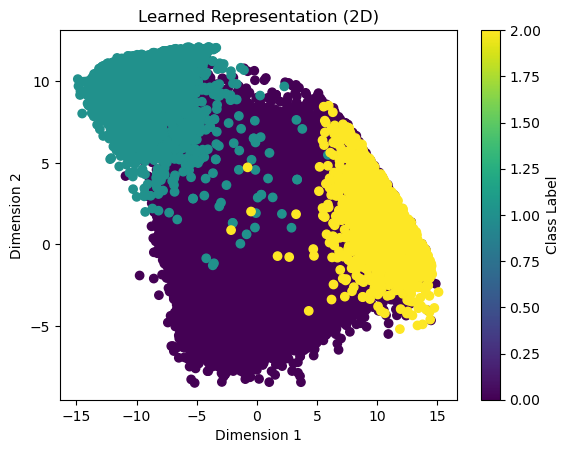

In [9]:
# Combine reduced representation and labels into a single array
data = np.column_stack((reduced_representation, y_train))

# Sort the data based on class labels
sorted_data = data[data[:, 2].argsort()]

# Your existing code for scatter plot
scatter_plot = plt.scatter(sorted_data[:, 0], sorted_data[:, 1], c=sorted_data[:, 2], cmap='viridis')
plt.title('Learned Representation (2D)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Adding color legend
plt.colorbar(scatter_plot, label='Class Label')

# Display the plot
plt.show()